# Makemore Part 4

Understand backprop - 
you will need to understand how it works under the ood if you're wanting to debug it
examples
- case of dead neurons
- exploding or vanishing gradients
- clip loss of outlier, you are setting its gradient to zero

karpathy.medium.com 


In [3]:

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# is this a good model?
# loss may get close to zero by increasing model size
# if you try to evaluate on withheld names, loss can be high
# so standard in the field is to split dataset into three splits
# training, validation, test 
# 80%, 10%, 10%

# 80% used to optimize model params
# 10% used for hyperparams optimization 
# see which ones work best for validation split
# 10% used for evaluating model at end
# every tiem you evaluate your test loss, you're starting to train on test split
# so only allowed to test on test split very few times, otherwise you risk overfitting to it
block_size = 3

# context length: how many characters do we take to predict the next one?
def build_dataset(words):
    X,Y=[],[] # x input to NN, Y labels
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)     
            Y.append(ix)
            # print(context, ix)
            # this context takes the second character til the end 
            # so always trims off the first character
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# RESET part 2 with training data set
Xtr # input data
Ytr # labels
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27
hidden_layer_size = 200
embed_dims = 10
C = torch.randn((vocab_size,embed_dims), generator=g)
W1 = torch.randn((block_size * embed_dims, hidden_layer_size), generator=g)
b1 = torch.randn((hidden_layer_size,))
W2 = torch.randn((hidden_layer_size, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size,), generator=g) * 0
parameters = [C,W1,b1,W2,b2]

for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

11897


In [8]:
# set up neural network
# single batch
# loss doesn't go to zero, but ... predicts multiple values
# so loss can never go to zero
# this is also only a single batch, so 3481 parmaeters
# easy to fit to this batch.

# we want to randomly select a mini batch and forward and update on minibatch
# better to have approximate gradient and take many steps
# than exact gradient with fewer steps
stepi = []
lossi = []
max_steps = 200000
batch_size = 32
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward
    emb = C[Xtr[ix]] 
    embcat = emb.view(-1,block_size * embed_dims)
    hpreact = embcat @ W1 + b1
    h1 = torch.tanh(hpreact)
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update, learning rate increases over time
    # keep track of learning rates we use and look at 
    # losses that resulted
    if i > 200000:
        lr = 0.01
    elif i > 100000:
        lr = 0.05 # 1e-1 # lrs[i] # decay learning rate 
    else:
        lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
    stepi.append(i)
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.296663


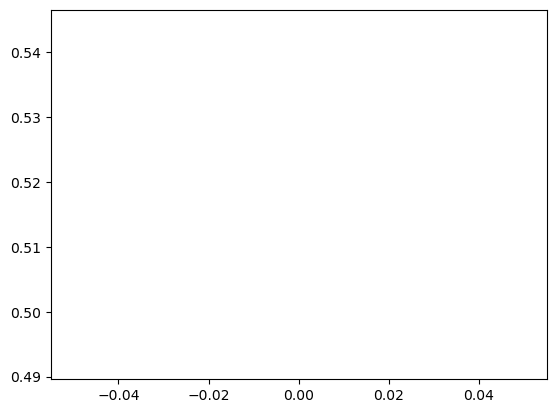

In [9]:
plt.plot(stepi, lossi)

In [10]:
# evaluate loss for TRAINING SEt
@torch.no_grad()
def print_loss():
    emb = C[Xtr]
    h = torch.tanh(emb.view(-1,block_size * embed_dims) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr)
    print("training_loss", loss.item())

    # training and dev loss are about equal
    # this means we can scale up the size we are underfitting.

    # easiest way to do this is to scale up hidden layers
    # evaluate loss for DEV SET
    emb = C[Xdev]
    h = torch.tanh(emb.view(-1,block_size * embed_dims) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ydev)
    print("validation_loss", loss.item())
print_loss()

training_loss 3.1805362701416016
validation_loss 3.1789357662200928


In [11]:
# Sample from model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (3,block_size, d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carpzhxqtb.
hqvufkwmrpxqthtykhkcasskejrzhnbnfqpwsyhc.
vgqeiu.
rrmuqptcmziivduxleggphhbm.
poin.
qbqjtzsrlivwa.
vvdbquwqzerogdjaryxixfkqeupiusdbwed.
ecoia.
gtlffhysflquhpagmbvdjhksyjipmqqosozewjcojqmwyojsfrenqkpfsadlnuo.
zoebsvkoiazhrynhg.
opklhynrxah.
xqioboqbrrbvbwdn.
apyqmuitjgbvfpzpddgpycsislqwkkmcrnzauqnljydrk.
kvweskattmzamdtevl.
ky.
adyctoorowooktbymomokfbfcj.
zolndzcs.
au.
eoaiunqqeroqci.
icjzykbadykgluclconqzyzdjokhnlhjjqsxmuadmtjhvtoiawlwuw.


In [12]:
# PROBLEM 1
# first, we can figure out that initialization is bad
# because loss is around 27 to start. but we don't believe any character
# is more likely than any other. this rapidly comes down to 1 or 2

# in training of NN, it's almost always the case you will have an idea of 
# what loss to expect at initialization

# we can calculate this
# at init: 27 chars to come next for any training example
# at init, no reason to believe anything is more likely than others
# uniform distribution 
# prob for any char is ~ 1/27.0

-torch.tensor(1/27.0).log()

# so what is happening is that NN is creating prob dist that are very bad
# then network is confidently wrong. this is what makes it very high loss

# with more extreme values, you are more likely to be guessing the wrong value confidently
# we want logits to be roughly zero when 
# or roughly equal to start

# so how can we achieve logits that come out better?
# don't add bias of random numbers

# b2 = 0
# h @ W2 - if we want logits small, scale down W2 by 
# h @ W2 * .1

# why don't you want to set W2 to 0?
# because you want some entropy
# now loss doesn't look like hockey stick
# loss is quite a bit improved. now to 2.15
# training_loss 2.1070516109466553
# validation_loss 2.1754932403564453

tensor(3.2958)

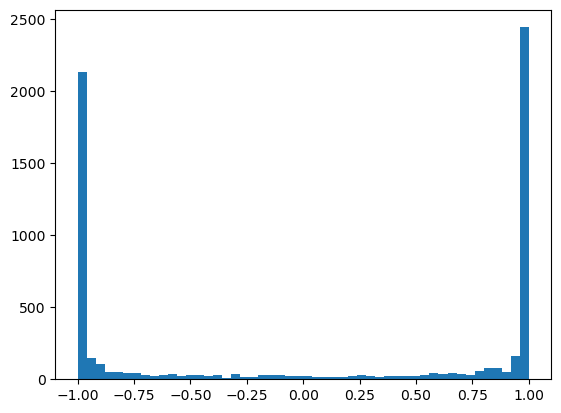

In [13]:
# PROBLEM 2
# a deeper problem in initialization
# logits are OK
# problem is with values of h
# activations of hidden states
# roughly speaking, many values of h are 1 or -1
# tanh is a squashing function. takes arbitrary numbers
# into range of -1 to 1

h1.shape
plt.hist(h1.view(-1).tolist(),50);

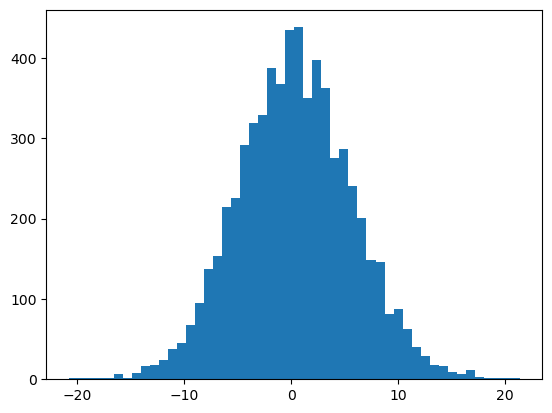

In [ ]:
# this tanh is very very active. 
# we look at preactivations 
plt.hist(hpreact.view(-1).tolist(),50);

# we see distribution of preactivations take numbers between -15 to 15
# this is why everything is between -1 to 1, why so many values take on extreme values

# why is this an issue?
# if you have an intuitive sense of how these gradients flow thorugh the network
# during backprop - you are flowing through the loss backwards
# propagate through tanh, 200 neurons for each example
# implements tanh backward pass is 
# tanh(self):
# x = self.data
# def backward
    # (1 - t**2) * out.grad # t squaredi
    # if t is 1 or t is -1, out.grad essentially STOPs
    # if output is very close to 1 or -1, then changing input
    # basically doesn't impact the output of tanh because it's in
    # the flat area of the loss.
    # the weights and biases don't impact loss and there is no influence
    # the gradient **vanishes**
    # when t is 0, out.grad is passed through
    # the more you are in the flat tails, the more the gradient is squashed
    # the amount it decreases is proportional to square 

# so the concern is if all the outputs are in the flat area
# the gradients that are flowing through the network will get destroyed at this layer.

# leaky relu will not suffer as much because it's not flat

In [54]:
# Copied from above
Xtr # input data
Ytr # labels
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27
hidden_layer_size = 200
embed_dims = 10
C = torch.randn((vocab_size,embed_dims), generator=g)
W1 = torch.randn((block_size * embed_dims, hidden_layer_size), generator=g) * (5/3) / (embed_dims * block_size)**0.5 # 0.2
b1 = torch.randn((hidden_layer_size,)) * 0.01
W2 = torch.randn((hidden_layer_size, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size,), generator=g) * 0
parameters = [C,W1,b1,W2,b2]

for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

11897


In [55]:
# set up neural network
# single batch
# loss doesn't go to zero, but ... predicts multiple values
# so loss can never go to zero
# this is also only a single batch, so 3481 parmaeters
# easy to fit to this batch.

# we want to randomly select a mini batch and forward and update on minibatch
# better to have approximate gradient and take many steps
# than exact gradient with fewer steps
stepi = []
lossi = []
max_steps = 200000
batch_size = 32
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward
    emb = C[Xtr[ix]] 
    embcat = emb.view(-1,block_size * embed_dims)
    hpreact = embcat @ W1 + b1
    h1 = torch.tanh(hpreact)
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update, learning rate increases over time
    # keep track of learning rates we use and look at 
    # losses that resulted
    if i > 200000:
        lr = 0.01
    elif i > 100000:
        lr = 0.05 # 1e-1 # lrs[i] # decay learning rate 
    else:
        lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
    stepi.append(i)
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.321971
  10000/ 200000: 2.562582


KeyboardInterrupt: 

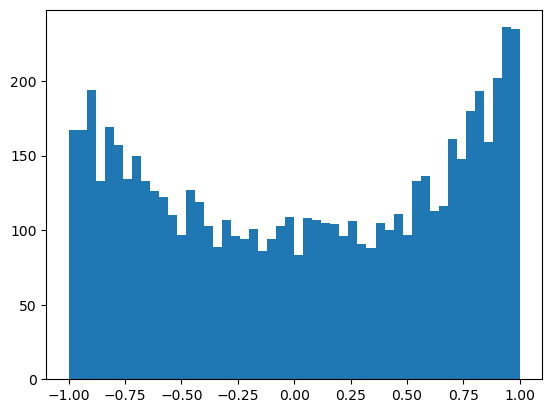

In [24]:
# compare the shape of h1 now to before and you can see that it's very different in terms of shape, with most values falling around 0

h1.shape
plt.hist(h1.view(-1).tolist(),50);

# hist

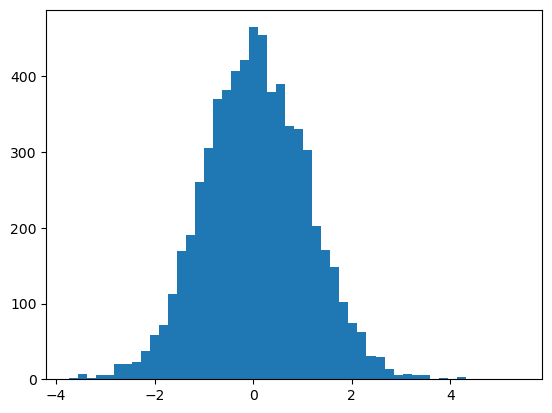

In [25]:
plt.hist(hpreact.view(-1).tolist(),50);

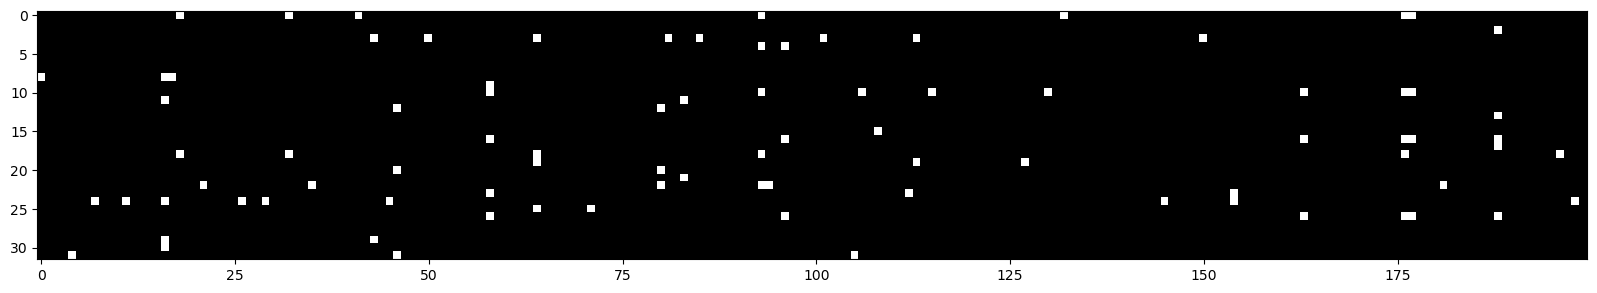

In [26]:
plt.figure(figsize=(20,10))
plt.imshow(h1.abs() > 0.99, cmap='gray', interpolation='nearest')

In [28]:
# Loss Log - rerun with new initialized values

print_loss()

# w/improvement of W2 and b2
# fix softmax confidently wrong
# loss is quite a bit improved. now to 2.15
# training_loss 2.1070516109466553
# validation_loss 2.1754932403564453

# w/improvement of W1 and b1
# fix tanh layer too saturated at init
# training_loss 2.0695881843566895
# validation_loss 2.1435439586639404 
#

# these problems tend to stack up, can get to the place where training doesn't happen at all
# (not forgiving to these errors) as the depth of the NN increases


training_loss 2.0695881843566895
validation_loss 2.1435439586639404


tensor(-0.0060) tensor(0.9944)
tensor(0.0011) tensor(1.0175)


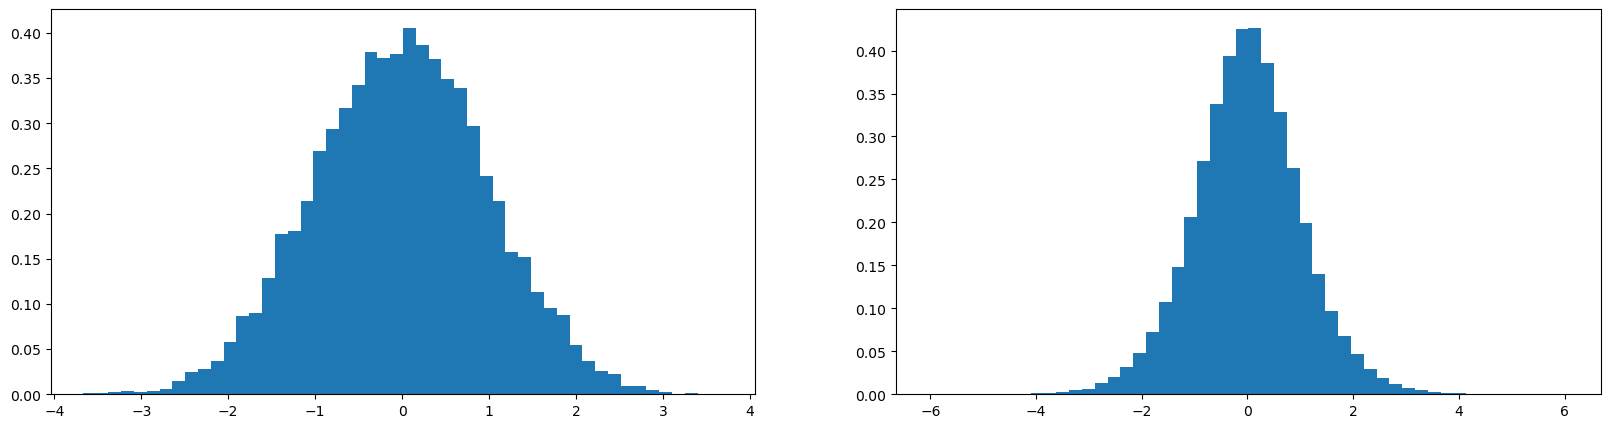

In [33]:
# now we have a lot of magic numbers. How do we set this if there are lots of layers?

x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# the std deviation has grown to 3, this gaussian is expanding from the input.
# we don't want this, we want essentially unit gaussian throughout the NN
# how do we scale these to remain a gaussian?

# outputs in number y as we scale up take more extreme values
# what do you multiple to exactly preserve std dev = 1?
# you are supposed to divide by teh sqrt of the fan in
# the number of inputs 

# how do you initialize weights to stay consistent.
# Kaiming He - deliving deep into rectifiers.
# Study ReLU and PReLU, analysis is very similar.
# for them ReLU is a squashing function where all negative numbers are clamped to 0, pos numbers are passthrough
# because you throw away half the distribution, you have to compensate with sqrt 1/fan-in 
# they had to multiply by 2 because ReLU throws away half the distribution.
# this paper also studied the back propogation case
# what they find here if you properly initialize forward pass, the backwards passes properly initialize as well
# up to a certain constant

# torch.nn.init.kaiming_normal(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
# mode: normalie the activations or the gradients to always be gaussian normal
# paper finds this doesn't mater too much, so people leave it as fan_in
# pass in nonlinearity - you will get slightly different gain depending on values

# why do you need gain on top of the initialization?
# because tanh is a contractive operation
# you take values and squash it
# tanh takes the tails and squeeze them in
# to fight the squeezing in, you need to renormalize everything to std dev

# about 7 years ago when this paper was written, had to be very careful about activatiosn and ranges
# and scrutinizing of non-linearities, everything was finicky and fragile, esp if NN is deep
# modern innovations have made things more stable and well-behaved

# such as residual connections
# use of normalization layers such as batch, group, layer normalization
# better optimizers than stochastic gradient descent (RMSprop and ADAM)
# these make it less important to calculate the initialization of the NN

# in practice, generally normalize by sqrt of the fan in



In [36]:
(torch.randn(10000 ) * 0.2).std()

tensor(0.2010)

In [37]:
# multiply by gain, which for tanh is 5/3
(5/3) / (embed_dims * block_size)**0.5

0.3042903097250923

In [40]:
# Loss Log - rerun with new initialized values

print_loss()

# w/improvement of W2 and b2
# fix softmax confidently wrong
# loss is quite a bit improved. now to 2.15
# training_loss 2.1070516109466553
# validation_loss 2.1754932403564453

# w/improvement of W1 and b1
# fix tanh layer too saturated at init
# training_loss 2.0695881843566895
# validation_loss 2.1435439586639404 
#

# w/kaiming loss
# training_loss 2.069835901260376
# validation_loss 2.1448299884796143


training_loss 2.069835901260376
validation_loss 2.1448299884796143


# Batch Normalization

In [ ]:
# important enhancement that allowed training of NNs more reliably
# basically jusit worked

In [41]:
# we want activations at initilaization to be roughly gaussian
# we have hidden states and want them to be roughly gaussian.
# why not just normalize hidden states to be roughly gaussian?

# standardizing hidden states to be gaussian is differentiable
# if you like gaussian states in your network, you can just nromalize them to be unit gaussian

hpreach = embcat @ W1 + b1 # we want this to be roughly gaussian
# standardize these activations to be roughly gaussian
hpreact.shape

torch.Size([32, 200])

In [49]:
hpreact.mean(0, keepdim=True).shape

# subtract mean and divide by std dev
hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)

# what this does is every neuron and firing rate is exactly unit gaussian over batch
# that's why it's called batch normalization

# we could in principle train this, but we won't get a very good result
# the reason we want these to be roughly gaussian but only at initialization.
# we want NN to move this around (make more diffuse or sharp) to make some tanh neurons more trigger happy

# in addition to this idea to std activations, we have to also introduce scale and shift
# additionally scale by some gain and offset by some bias to get final output
bngain = torch.ones((1, hidden_layer_size)) # batch normal gain, shape of 1, n_hidden
bnbias = torch.zeros((1, hidden_layer_size))

hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)) + bnbias

# we'll be able to backprop bngain and bnbias to do wahtever we want
# include these in paramts of the NN



12297


In [58]:
# Copied from above
Xtr # input data
Ytr # labels
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27
hidden_layer_size = 200
embed_dims = 10
C = torch.randn((vocab_size,embed_dims), generator=g)
W1 = torch.randn((block_size * embed_dims, hidden_layer_size), generator=g) * (5/3) / (embed_dims * block_size)**0.5 # 0.2
b1 = torch.randn((hidden_layer_size,)) * 0.01
W2 = torch.randn((hidden_layer_size, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size,), generator=g) * 0
bngain = torch.ones((1, hidden_layer_size)) # batch normal gain, shape of 1, n_hidden
bnbias = torch.zeros((1, hidden_layer_size))
parameters = [C,W1,b1,W2,b2,bngain,bnbias]

for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

12297


In [61]:
# set up neural network
# single batch
# loss doesn't go to zero, but ... predicts multiple values
# so loss can never go to zero
# this is also only a single batch, so 3481 parmaeters
# easy to fit to this batch.

# we want to randomly select a mini batch and forward and update on minibatch
# better to have approximate gradient and take many steps
# than exact gradient with fewer steps
stepi = []
lossi = []
max_steps = 200000
batch_size = 32
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward
    emb = C[Xb] 
    embcat = emb.view(-1,block_size * embed_dims)
    hpreact = embcat @ W1 + b1
    # batch norm
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h1 = torch.tanh(hpreact)
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # print(loss)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update, learning rate increases over time
    # keep track of learning rates we use and look at 
    # losses that resulted
    if i > 200000:
        lr = 0.01
    elif i > 100000:
        lr = 0.05 # 1e-1 # lrs[i] # decay learning rate 
    else:
        lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
    stepi.append(i)
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.309246
  10000/ 200000: 2.717775
  20000/ 200000: 2.195012
  30000/ 200000: 1.899718
  40000/ 200000: 2.108541
  50000/ 200000: 1.831086
  60000/ 200000: 2.393445
  70000/ 200000: 2.270220
  80000/ 200000: 2.070730
  90000/ 200000: 2.381815
 100000/ 200000: 2.476407
 110000/ 200000: 2.111832
 120000/ 200000: 2.019737
 130000/ 200000: 2.133682
 140000/ 200000: 2.245491
 150000/ 200000: 2.002614
 160000/ 200000: 2.247063
 170000/ 200000: 2.275235
 180000/ 200000: 2.229887
 190000/ 200000: 2.279107


In [ ]:
# Loss Log - rerun with new initialized values

# evaluate loss for TRAINING SEt
@torch.no_grad()
def print_loss():
    emb = C[Xtr]
    embcat = emb.view(-1,block_size * embed_dims)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)

    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr)
    print("training_loss", loss.item())

    # training and dev loss are about equal
    # this means we can scale up the size we are underfitting.

    # easiest way to do this is to scale up hidden layers
    # evaluate loss for DEV SET
    emb = C[Xdev]
    embcat = emb.view(-1,block_size * embed_dims)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ydev)
    print("validation_loss", loss.item())
print_loss()

# w/improvement of W2 and b2
# fix softmax confidently wrong
# loss is quite a bit improved. now to 2.15
# training_loss 2.1070516109466553
# validation_loss 2.1754932403564453

# w/improvement of W1 and b1
# fix tanh layer too saturated at init
# training_loss 2.0695881843566895
# validation_loss 2.1435439586639404 
#

# w/kaiming loss
# training_loss 2.069835901260376
# validation_loss 2.1448299884796143

# w/batch normalization
# training_loss 2.0905706882476807
# validation_loss 2.138423442840576


training_loss 2.0905706882476807
validation_loss 2.138423442840576


In [ ]:
# there isn't much improvement here
# but it's common to look at every linear layer or convolutions, customary to take these LL and append a batch norm right after it
# this controls scale of activations throughout NN
# doesn't require perfect mathematics for all these NN lego building blocks
# significantly stabilizes the training

# stability comes at a cost.
# something strange and unnatural is happening.device
# before calculate single value, activations and logits. this was deterministic
# because of efficiency of training we used batches
# batches were processed independently, but because of batch normalization
# we are coupling these examples in forward and backward pass 
# any one logits are not just function of inputs / outputs, but also other samples that came in the batch

# hpreact is going to change slightly depending on what other samples are in the batch
# depending on what other samples come in the batch, hpreact will jitter because of the statistics
# of the mean and std dev and logits are moving

# this tends to be good in NN training, because it's kind of like a regularizer
# adding entropy to batch. kind of a form of data augmentation
# makes it harder to overfit

# second order effect is that batch norm is a regularizer. this makes it harder for us to remove 
# the batch normalizer. No one likes it to be coupled in teh forward pass 
# leads to a lot of bugs 
# people have tried to deprecate the use of normalization and move to other that don't couple with batch

# long story short, batch was first normalization layer to be introduced and happened to have regularizing effect
# people have been trying to move to other but it's been hard because it works quite well
# effective at controling activations

In [64]:
# a weird thing - how do we get single answers out when we expect batches?
# have an additional set that calculates the mean and std a single time

with torch.no_grad():
    # pass through training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

@torch.no_grad()
def print_loss():
    emb = C[Xtr]
    embcat = emb.view(-1,block_size * embed_dims)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)

    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr)
    print("training_loss", loss.item())

    # training and dev loss are about equal
    # this means we can scale up the size we are underfitting.

    # easiest way to do this is to scale up hidden layers
    # evaluate loss for DEV SET
    emb = C[Xdev]
    embcat = emb.view(-1,block_size * embed_dims)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ydev)
    print("validation_loss", loss.item())
print_loss()


training_loss 2.0905706882476807
validation_loss 2.138542890548706


In [71]:
# Copied from above
Xtr # input data
Ytr # labels
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27
hidden_layer_size = 200
embed_dims = 10
C = torch.randn((vocab_size,embed_dims), generator=g)
W1 = torch.randn((block_size * embed_dims, hidden_layer_size), generator=g) * (5/3) / (embed_dims * block_size)**0.5 # 0.2
# b1 = torch.randn((hidden_layer_size,)) * 0.01
W2 = torch.randn((hidden_layer_size, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size,), generator=g) * 0
bngain = torch.ones((1, hidden_layer_size)) # batch normal gain, shape of 1, n_hidden
bnbias = torch.zeros((1, hidden_layer_size))
bnmean_running = torch.ones((1, hidden_layer_size))
bnstd_running = torch.zeros((1, hidden_layer_size))
parameters = [C,W1,W2,b2,bngain,bnbias]

for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

# authors also introduced idea to keep a running mean and std deviation
stepi = []
lossi = []
max_steps = 200000
batch_size = 32
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward
    emb = C[Xb] 
    embcat = emb.view(-1,block_size * embed_dims)
    hpreact = embcat @ W1
    # batch norm
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    # non-linearity
    h1 = torch.tanh(hpreact)
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # this update is outside of the gradient based optimization
    # updating janky running mean manner. while network is training
    # preactivations are changing, we are keeping track of typical std dev
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update, learning rate increases over time
    # keep track of learning rates we use and look at 
    # losses that resulted
    if i > 200000:
        lr = 0.01
    elif i > 100000:
        lr = 0.05 # 1e-1 # lrs[i] # decay learning rate 
    else:
        lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())

12097
      0/ 200000: 3.323671
  10000/ 200000: 2.021117
  20000/ 200000: 2.275626
  30000/ 200000: 1.968111
  40000/ 200000: 2.076465
  50000/ 200000: 1.956514
  60000/ 200000: 1.933560
  70000/ 200000: 2.668336
  80000/ 200000: 2.031192
  90000/ 200000: 2.301463
 100000/ 200000: 1.891542
 110000/ 200000: 2.349247
 120000/ 200000: 1.932249
 130000/ 200000: 2.526676
 140000/ 200000: 2.328694
 150000/ 200000: 1.826006
 160000/ 200000: 2.048131
 170000/ 200000: 2.469351
 180000/ 200000: 2.117570
 190000/ 200000: 1.928482


In [68]:
# now during inference, use the estimated running mean of these hidden states

with torch.no_grad():
    # pass through training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

bnmean

tensor([[-3.0795,  0.6527, -1.3972,  0.8402,  0.9960,  1.0252,  1.9811, -1.3854,
          1.2361,  1.4696, -1.9303, -2.1102, -0.2891, -0.6550,  0.2609, -0.7097,
          1.4590, -2.7233, -0.0133,  0.9239, -0.9583, -0.5221, -0.9768,  0.3826,
          1.3733,  0.7046,  1.2487,  1.0525,  1.2435,  1.5748, -0.6240, -1.9036,
         -0.3904,  0.5248, -0.0176, -1.2971, -1.6338,  0.8806, -0.4114,  1.2176,
          0.4973, -1.6544, -0.3748,  0.1685,  1.5145,  1.1650,  1.6949, -0.2456,
          2.5940,  1.2306,  1.0932,  0.3124,  2.2164,  1.1303,  1.2343, -1.9974,
         -0.4040,  0.1005,  1.5299, -0.7845, -0.4820,  0.8150,  0.5294,  0.6423,
          1.6542,  0.9351, -0.3423,  2.2170, -0.9986, -0.1152, -0.3367,  0.6751,
         -0.4378, -0.9726, -2.8241,  0.2511,  1.4498, -0.4858,  0.6320,  1.0699,
         -0.4107,  1.5893,  1.6823,  0.7557, -0.0774, -1.4600, -0.5041, -0.0246,
          1.5617, -0.1504, -1.1016,  1.1891, -0.9274, -1.2330, -0.7191,  0.5282,
          0.1469, -0.4594, -

In [67]:
bnmean_running

tensor([[-3.0778,  0.6809, -1.3876,  0.8189,  1.0000,  1.0386,  1.9458, -1.3538,
          1.2029,  1.4489, -1.9656, -2.1274, -0.2814, -0.6799,  0.2229, -0.6941,
          1.4509, -2.7091, -0.0332,  0.9160, -0.9441, -0.5305, -0.9464,  0.3885,
          1.3723,  0.7213,  1.2360,  1.0386,  1.2220,  1.5583, -0.6215, -1.8966,
         -0.3623,  0.5125, -0.0130, -1.3166, -1.6624,  0.8780, -0.3885,  1.2007,
          0.4818, -1.6404, -0.3817,  0.1808,  1.4919,  1.1614,  1.7042, -0.2917,
          2.6154,  1.2314,  1.1387,  0.2975,  2.1807,  1.1219,  1.2442, -1.9860,
         -0.3908,  0.0959,  1.5513, -0.7499, -0.4700,  0.8283,  0.5330,  0.6848,
          1.6379,  0.9375, -0.3351,  2.2136, -0.9991, -0.0954, -0.3465,  0.6548,
         -0.4459, -0.9641, -2.8281,  0.2863,  1.4501, -0.5001,  0.6387,  1.0305,
         -0.3858,  1.5794,  1.6683,  0.7781, -0.0658, -1.4866, -0.5001, -0.0208,
          1.5976, -0.1716, -1.0906,  1.1741, -0.9193, -1.2155, -0.7030,  0.5410,
          0.1505, -0.4807, -

In [69]:
# these are now fairly similar (bmean and bmean_running)
# now we don't need a second stage
# this is how batch norm in pytorch is implemented
@torch.no_grad()
def print_loss():
    emb = C[Xtr]
    embcat = emb.view(-1,block_size * embed_dims)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)

    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr)
    print("training_loss", loss.item())

    # training and dev loss are about equal
    # this means we can scale up the size we are underfitting.

    # easiest way to do this is to scale up hidden layers
    # evaluate loss for DEV SET
    emb = C[Xdev]
    embcat = emb.view(-1,block_size * embed_dims)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ydev)
    print("validation_loss", loss.item())
print_loss()

training_loss 2.086935520172119
validation_loss 2.1289987564086914


In [ ]:
# we're being wasteful here, because biases are being added then subtracted out.append
# b1.grad is going to be zero.
# you're better off just not using bias when you're using batch normalization
# you have batch_normalizing bias instead of b1

# summary

We're using batch normalization to control the statistics of the activations in the NN. it's is common to sprinkle it in the NN, usually place it after layers that have multiplcationats (LL or convolutions). Batch normalization internally has parameters for gain and bias, and therse are trained with back prop, it also has buffers, running mean and running std dev, these are not trained using backprop, but computed via running mean.

Really what this is doing is calculating the mean and std dev of the activations feeding into the BN layer, then centering this batch to be unit gaussian, then offsetting it and multiplying by the bngain and bnbias, keeping track of the inputs. This will later be used at inference so we don't have to re-esitimate mean and std afterwards. This allows us to forward individual examples at inference time.

ResNets in detail: note that image feeds into ResNet, many many layers of repeating structures, sequentially stacked in a NN.

Code for this in series is called Bottleneck block. 
Init layer
in forward, specify how NN acts with the inputs
blocks are replicated and stacked serially which is what resnet is

search: pytorch resnet 

In [73]:
n = [1,2,3,4,5,6,7,8,9]
n[:-1]

[1, 2, 3, 4, 5, 6, 7, 8]